100%|██████████| 170498071/170498071 [00:06<00:00, 27507456.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [0/10], Step [0/782], Generator Loss: 0.7285, Discriminator Loss: 1.3908
Epoch [0/10], Step [100/782], Generator Loss: 1.9259, Discriminator Loss: 0.5639
Epoch [0/10], Step [200/782], Generator Loss: 3.5225, Discriminator Loss: 0.3051
Epoch [0/10], Step [300/782], Generator Loss: 4.7982, Discriminator Loss: 0.8115
Epoch [0/10], Step [400/782], Generator Loss: 2.7704, Discriminator Loss: 0.6123
Epoch [0/10], Step [500/782], Generator Loss: 3.2862, Discriminator Loss: 0.6582
Epoch [0/10], Step [600/782], Generator Loss: 2.0580, Discriminator Loss: 0.9732
Epoch [0/10], Step [700/782], Generator Loss: 1.6626, Discriminator Loss: 0.8057
Epoch [1/10], Step [0/782], Generator Loss: 2.3368, Discriminator Loss: 0.6896
Epoch [1/10], Step [100/782], Generator Loss: 1.9308, Discriminator Loss: 0.9359
Epoch [1/10], Step [200/782], Generator Loss: 2.7629, Discriminator Loss: 0.8185
Epoch [1/10], Step [300/

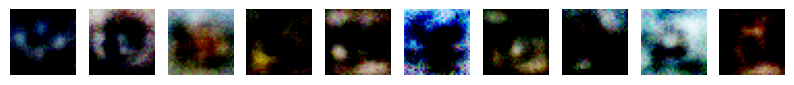

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

class CIFAR10Dataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.dataset = CIFAR10(root='./data', train=train, download=True, transform=self.transform)
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

train_dataset = CIFAR10Dataset(transform=transform, train=True)
valid_dataset = CIFAR10Dataset(transform=transform, train=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]
class_num = 10

class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, class_num):
        super().__init__()
        self.z_size = z_size
        self.label_emb = nn.Embedding(class_num, class_num)
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], 3 * 32 * 32),  # CIFAR-10 images have three channels and size 32x32
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(-1, self.z_size)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(-1, 3, 32, 32)  # Reshape to image size

class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, class_num):
        super().__init__()
        self.label_emb = nn.Embedding(class_num, class_num)
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32 + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(-1, 3 * 32 * 32)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

# Define generator and discriminator
generator = Generator(generator_layer_size, z_size, class_num).to(device)
discriminator = Discriminator(discriminator_layer_size, class_num).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        batch_size = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        # Train Discriminator
        discriminator.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Real images
        real_output = discriminator(images, labels)
        d_real_loss = criterion(real_output, real_labels)
        d_real_loss.backward()

        # Fake images
        z = torch.randn(batch_size, z_size, device=device)
        fake_images = generator(z, labels)
        fake_output = discriminator(fake_images.detach(), labels)
        d_fake_loss = criterion(fake_output, fake_labels)
        d_fake_loss.backward()

        d_optimizer.step()

        # Train Generator
        generator.zero_grad()
        z = torch.randn(batch_size, z_size, device=device)
        fake_images = generator(z, labels)
        outputs = discriminator(fake_images, labels)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_real_loss.item() + d_fake_loss.item():.4f}")

# Generate sample images
generator.eval()
with torch.no_grad():
    z = torch.randn(10, z_size, device=device)
    labels = torch.randint(0, class_num, (10,), device=device)
    samples = generator(z, labels).cpu()

# Plot sample images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)))
    plt.axis('off')
plt.show()
